In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# init and load image

In [20]:
import os
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
os.chdir(path_to_tissue_tag)
import tissue_tag as tt
import matplotlib.pyplot as plt
import scanpy as sc
output_notebook()
host = '5011'

Loading BokehJS ...

# Step 1 - Load image and define annotation names and colors 

(2704, 3949)


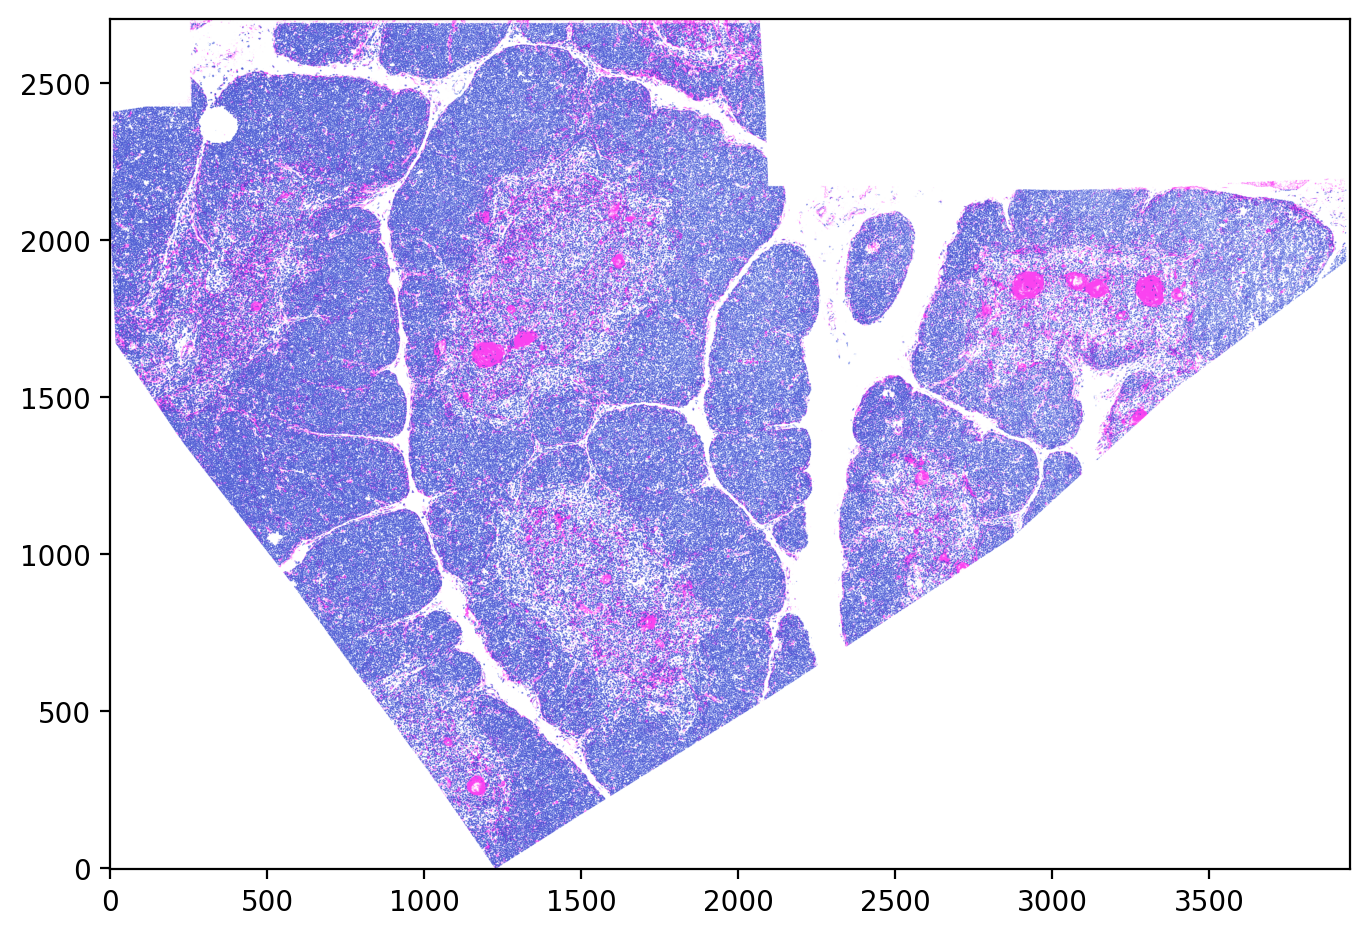

In [22]:
# here you can either read a single image (grayscale or RGB) or generate a virtial H&E from 2 images in the next cell
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
path = path_to_tissue_tag + 'data/tissue_tag_minimal_example_ibex/' 
im,_,ppm = tt.read_image(path+'Sample_05_THY45_Z5_ch0009.jpg',contrast_factor=2,background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg',ppm_image=3.5198,ppm_out=1)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(im,origin='lower')
# plt.savefig('/nfs/team205/ny1/IBEX/Thymus/dapi.png')

plt.show()

In [23]:
# define annotations Lv0 
annodict = {
    'unassigned':'yellow',
    'Artifacts':'black',
    'Medulla':'green',
    'Cortex':'cyan',
    'Edge':'brown',
    'HS':'magenta',
    'Vessels':'blue',
    'PVS':'red',
    'Other':'orange',
}

# Step 2 - (optional) Predict regions from image

## scribble initial annotations

In [24]:
p, render_dict = tt.scribbler(im,annodict)
def app(doc):
    global p
    doc.add_root(p)

show(app,notebook_url=f'{socket.gethostname()}:'+host) # determine if working on a server or local environment, if working on a local pc - 'local', while working on server instance indicate the port number e.g. 5011 (string)
print('wait for it.. can take a few tens of seconds on farm...')

wait for it.. can take a few tens of seconds on farm...


## extract and plot scribble anotations  

unassigned
Artifacts
Medulla
Cortex
Edge
HS
Vessels
PVS
Other


(2704, 3948, 4)

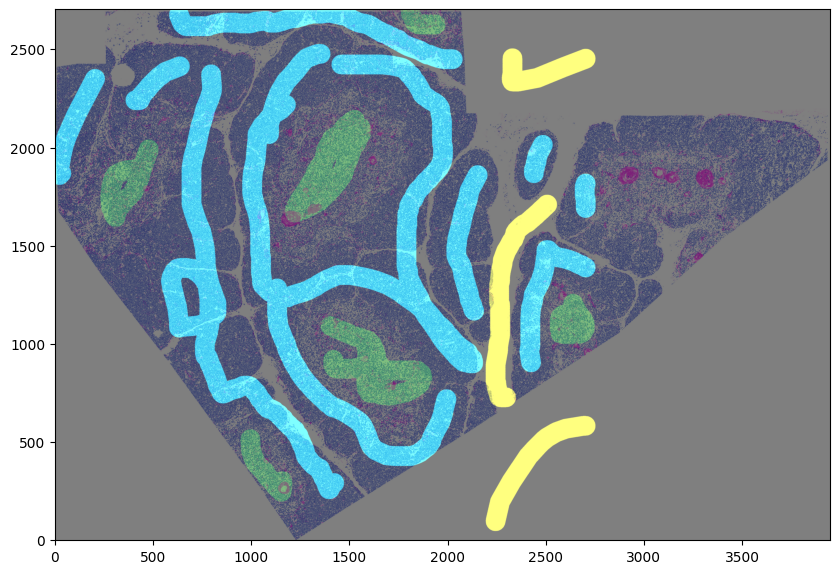

In [40]:
line_width = 100 # microns
training_labels = tt.scribble_to_labels(im,render_dict,line_width=line_width*ppm)
training_labels_rgb = tt.rgb_from_labels(training_labels,colors=list(annodict.values()))
tt.overlay_labels(im,training_labels_rgb,alpha=0.5)

im.shape

## run the RF classifier 

CPU times: user 1min 57s, sys: 8.93 s, total: 2min 6s
Wall time: 47.1 s


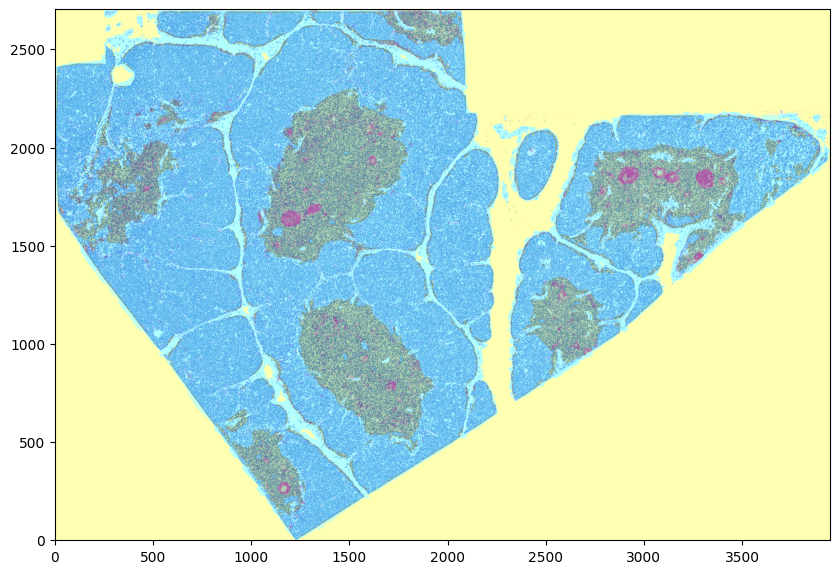

In [41]:
%%time
# this step takes about 30s to 5 min depending on number of training areas and resolution  
result = tt.sk_rf_classifier(im,training_labels)
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.7)

# Step 3 - Manually draw annotations or Correct forest annotations (Step 2)

In [53]:
# at this stage, if you are adding annotations make sure they come after the current ones otherwise it will mess up everything
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5,show=False)

tabs,render_dict = tt.annotator(im,out_img,anno_dict=annodict)

# plotting
def app(doc):     
    global tabs
    doc.add_root(tabs)
show(app,notebook_url=f'{socket.gethostname()}:'+host)
print('wait for it.. can take a few tens of seconds on farm... (double time of the former plot)')

wait for it.. can take a few tens of seconds on farm... (double time of the former plot)


## update annotations 

In [54]:
out_img, result = tt.update_annotator(im,result,anno_dict=annodict,render_dict=render_dict,alpha=0.5)


unassigned


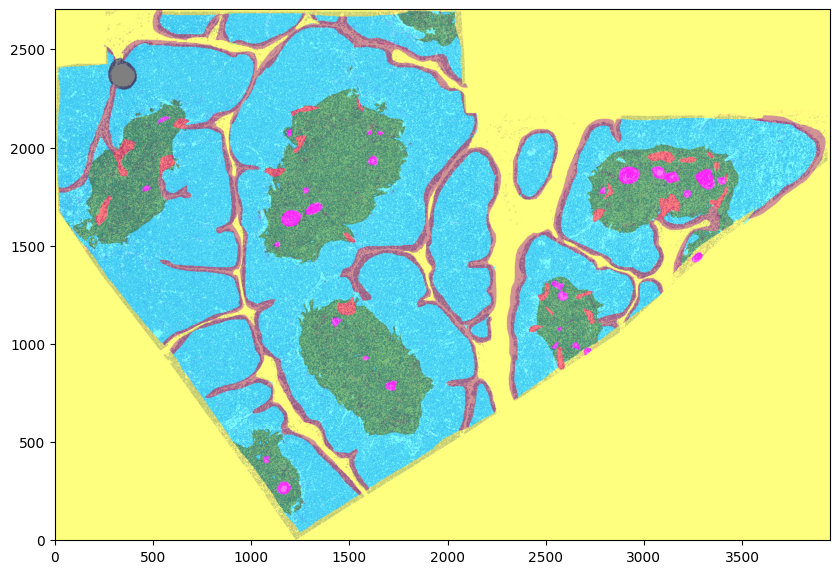

In [55]:
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)

# Step 4 - save annotations

In [58]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=path+'/tissue_annotations/',
    label_image=result,
    file_name='annotation_tissue',
    anno_names=list(annodict.keys()),
    anno_colors=list(annodict.values()),
    ppm = ppm,
    
)

# Step 5 - load annotations

loaded annotation image - annotation_tissue size - (2704, 3948)
loaded annotations
{1: 'unassigned', 2: 'Artifacts', 3: 'Medulla', 4: 'Cortex', 5: 'Edge', 6: 'HS', 7: 'Vessels', 8: 'PVS', 9: 'Other'}
loaded ppm
{'ppm': 1}
loaded color annotations
{'unassigned': 'yellow', 'Artifacts': 'black', 'Medulla': 'green', 'Cortex': 'cyan', 'Edge': 'brown', 'HS': 'magenta', 'Vessels': 'blue', 'PVS': 'red', 'Other': 'orange'}
(2704, 3948)
[1 2 3 4 5 6 8]


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

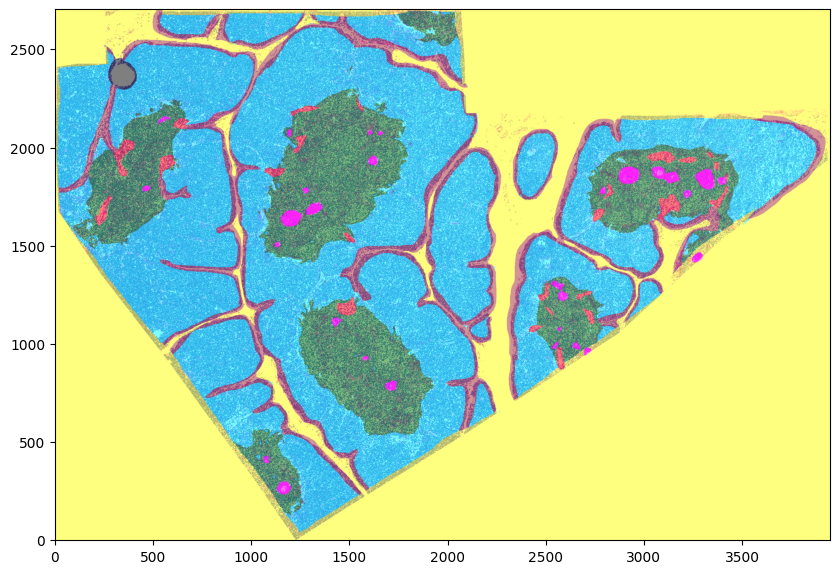

In [30]:
# load tissue annotations from jupyter annotator 
annotation_image,annotations_labels,ppm,annodict = tt.load_annotation(path+'/tissue_annotations/','annotation_tissue',load_colors=True)
im,ppm_image,_ = tt.read_image(path+'Sample_05_THY45_Z5_ch0009.jpg',contrast_factor=2,background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg',ppm_image=3.5198,ppm_out=ppm)
result_rgb = tt.rgb_from_labels(annotation_image,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)
print(np.unique(annotation_image))
annotation_image

## migrate annotations to hi res grid sapce 


In [31]:
%%time
# it's critical not to split cell part and recalculate the df everytime you cahnge the dist2cluster resolution - I have an overflow bug somewhere that I need to fix
spot_diameter = 20 # don't go crazy here avoid under 15um spots 
df = tt.grid_anno(
    im,
    [annotation_image],
    ['annotations'],
    [annotations_labels],
    spot_diameter=spot_diameter,
    ppm_in=ppm,
    ppm_out=ppm_image,
)
df

generating grid with spot size - 20, with resolution of - 1 ppm
annotations


26730it [00:03, 7989.60it/s]

CPU times: user 3.58 s, sys: 127 ms, total: 3.71 s
Wall time: 3.76 s


x            y annotations  annotations_number
index                                                         
0         70.3960    70.396000  unassigned                   1
1         70.3960   140.371722  unassigned                   1
2         70.3960   210.347445  unassigned                   1
3         70.3960   280.323181  unassigned                   1
4         70.3960   350.298889  unassigned                   1
...           ...          ...         ...                 ...
26725  13825.7744  9202.438042  unassigned                   1
26726  13825.7744  9272.413831  unassigned                   1
26727  13825.7744  9342.389621  unassigned                   1
26728  13825.7744  9412.365410  unassigned                   1
26729  13825.7744  9482.341200  unassigned                   1

[26730 rows x 4 columns]

In [67]:
# remove background spots
# df = df.iloc[np.where(df['annotations']!='unassigned')[0],:]

## move annotation and distances to cells (or anything that has xy coordinates)  

In [32]:
# read cell data 
df_cells = pd.read_csv(path+'sample_05_xy.csv')
df_cells

Unnamed: 0   centroid-0   centroid-1
0                0    21.049881  4322.589074
1                1    40.732535  4327.992016
2                2    40.332468  4362.800000
3                3    45.308157  4345.679758
4                4    52.028721  4311.151436
...            ...          ...          ...
112168      112168  9466.446809  3947.117021
112169      112169  9466.835366  4922.692073
112170      112170  9467.217514  6774.098870
112171      112171  9466.623288  2953.948630
112172      112172  9466.861111  6528.008333

[112173 rows x 3 columns]

In [33]:
# calculate distance matrix 
from scipy.spatial import distance_matrix, distance
a = np.vstack([df['x'],df['y']]).astype(int)
distM = distance.cdist(a.T,a.T, metric='euclidean')

calculating distances
Artifacts
Cortex
Edge
HS
Medulla
PVS
unassigned


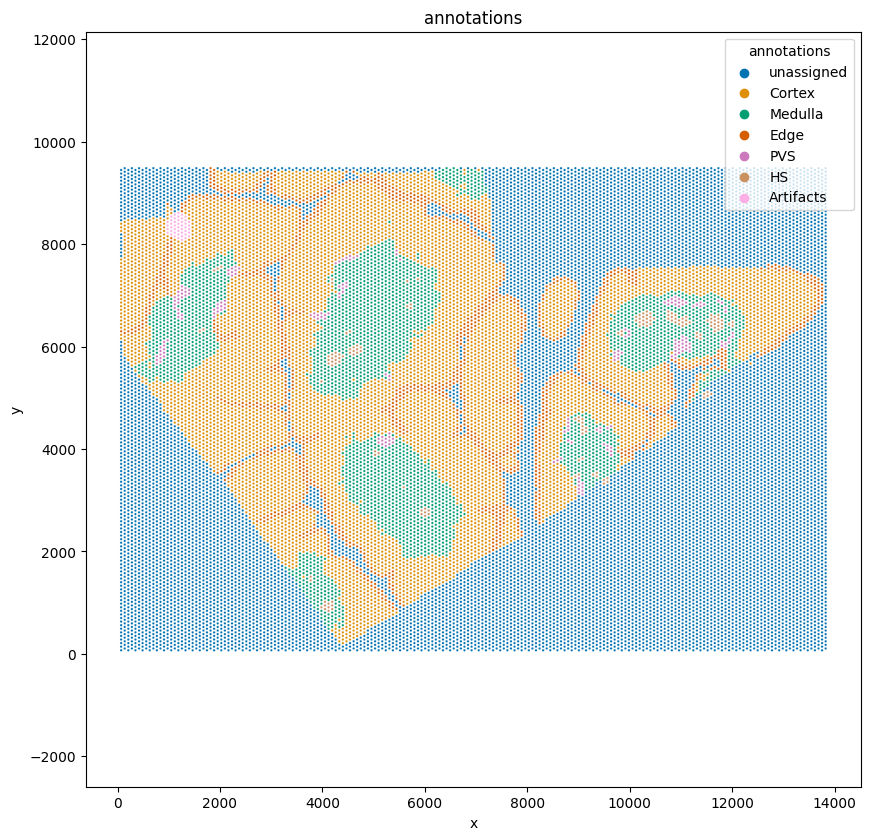

In [34]:
print('calculating distances')
tt.dist2cluster(df,annotation='annotations',distM=distM,resolution=1) # calculate minimum median distance of each spot to clusters 
tt.plot_grid(df,annotation='annotations',figsize=[10,10],spotsize=3)

make sure the coordinate systems are aligned e.g. axes are not flipped


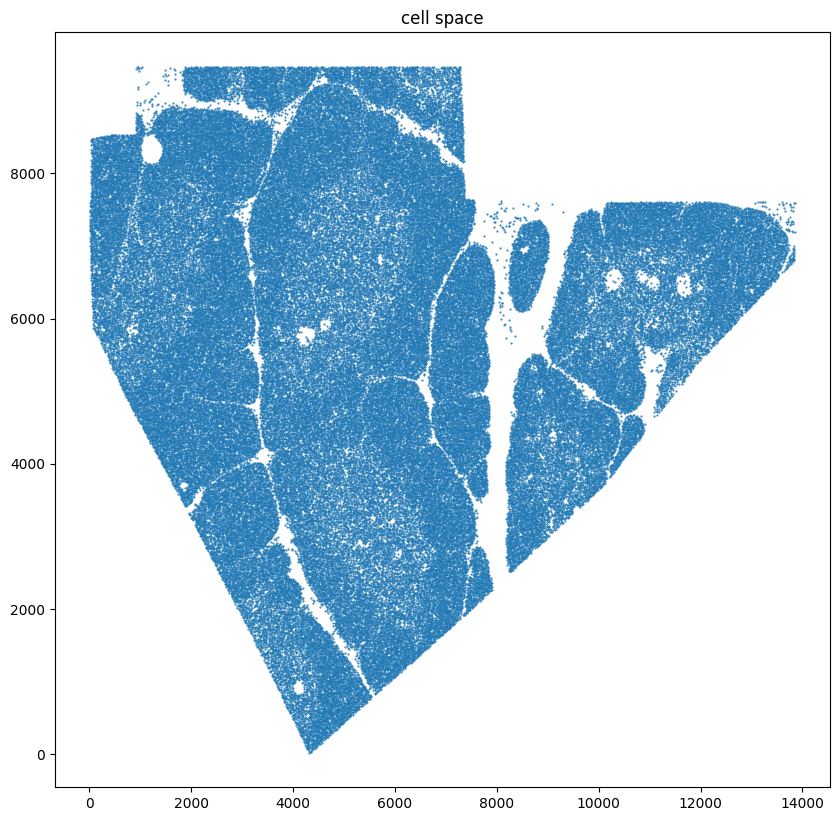

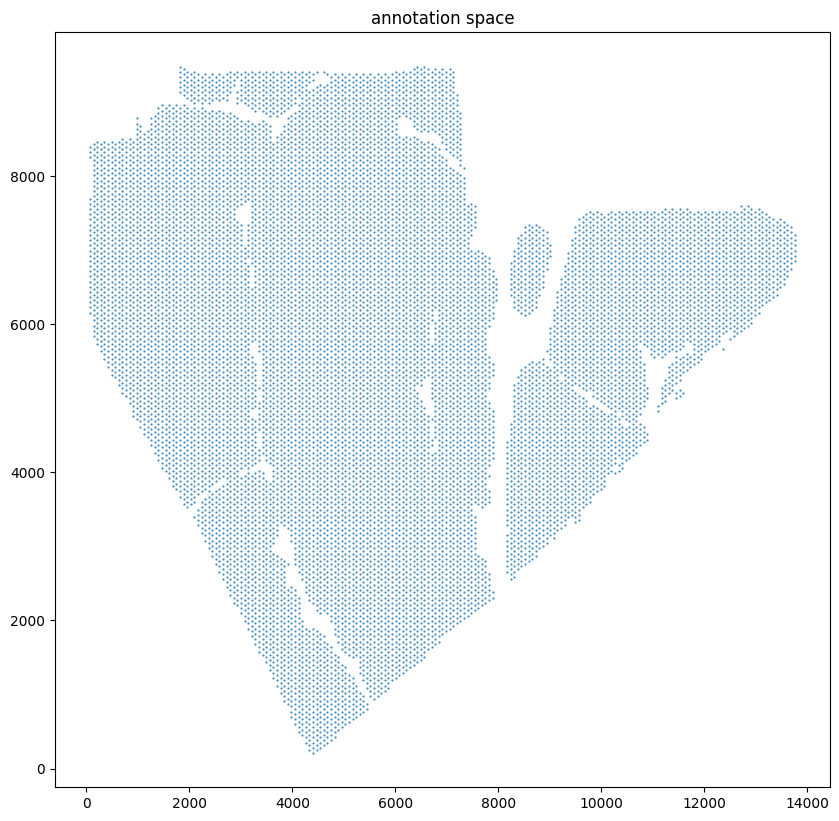

migrating - annotations to segmentations
migrating - annotations_number to segmentations
migrating - L2_dist_annotations_Artifacts to segmentations
migrating - L2_dist_annotations_Cortex to segmentations
migrating - L2_dist_annotations_Edge to segmentations
migrating - L2_dist_annotations_HS to segmentations
migrating - L2_dist_annotations_Medulla to segmentations
migrating - L2_dist_annotations_PVS to segmentations


Unnamed: 0   centroid-0   centroid-1 annotations  annotations_number  \
0                0    21.049881  4322.589074  unassigned                   1   
1                1    40.732535  4327.992016  unassigned                   1   
2                2    40.332468  4362.800000  unassigned                   1   
3                3    45.308157  4345.679758  unassigned                   1   
4                4    52.028721  4311.151436  unassigned                   1   
...            ...          ...          ...         ...                 ...   
112168      112168  9466.446809  3947.117021  unassigned                   1   
112169      112169  9466.835366  4922.692073  unassigned                   1   
112170      112170  9467.217514  6774.098870      Cortex                   4   
112171      112171  9466.623288  2953.948630  unassigned                   1   
112172      112172  9466.861111  6528.008333     Medulla                   3   

        L2_dist_annotations_Artifacts  L2_dist_annotations_Cortex  \
0                         8555.942263                  188.854441   
1                         8548.441846                  125.642350   
2                         8606.062282                  140.000000   
3                         8606.062282                  140.000000   
4                         8555.942263                  188.854441   
...                               ...                         ...   
112168                    2775.268275                   70.000000   
112169                    3645.487759                  125.642350   
112170                    5470.978066                    0.000000   
112171                    1860.590229                  155.630974   
112172                    5196.098633                  280.000000   

        L2_dist_annotations_Edge  L2_dist_annotations_HS  \
0                    1361.869671              782.445525   
1                    1288.459933              764.411538   
2                    1260.987312              818.987790   
3                    1260.987312              818.987790   
4                    1361.869671              782.445525   
...                          ...                     ...   
112168                376.961536             2144.307814   
112169                188.480768             2278.544492   
112170                770.000000             2318.750741   
112171                 70.000000             2128.400573   
112172                689.014514             2224.204352   

        L2_dist_annotations_Medulla  L2_dist_annotations_PVS  
0                        442.403662              4107.140733  
1                        420.000000              4056.693851  
2                        460.202130              4076.072252  
3                        460.202130              4076.072252  
4                        442.403662              4107.140733  
...                             ...                      ...  
112168                  1670.674714              1770.244051  
112169                  1130.513600              1704.283134  
112170                    78.262379              2058.859150  
112171                  1754.794575              2025.158265  
112172                     0.000000              1890.698548  

[112173 rows x 11 columns]

In [35]:
df_cells = tt.anno_to_cells(
    df_cells=df_cells,
    x_col='centroid-1', 
    y_col='centroid-0',
    df_grid=df, 
    annotation = 'annotations',
    plot=True
)
df_cells

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


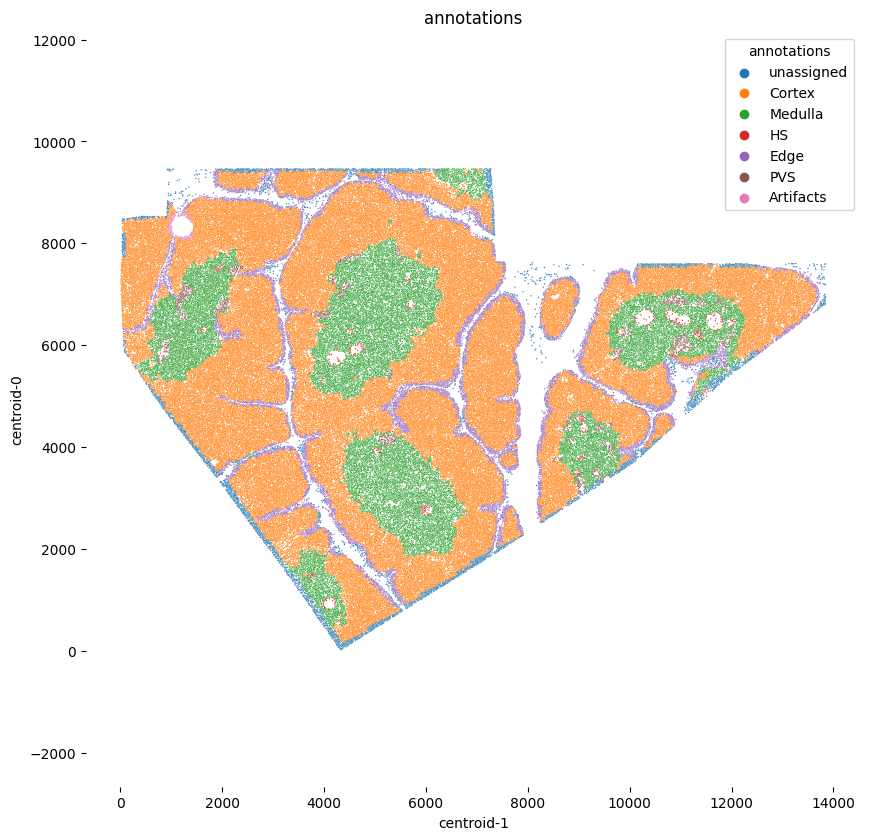

In [36]:
import seaborn as sns
plt.figure(dpi=100, figsize=[10,10])
sns.scatterplot(df_cells['centroid-1'],df_cells['centroid-0'],hue= df_cells['annotations'],cmap='tab10',s=1)
plt.grid(False)
plt.title('annotations')
plt.axis('equal')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


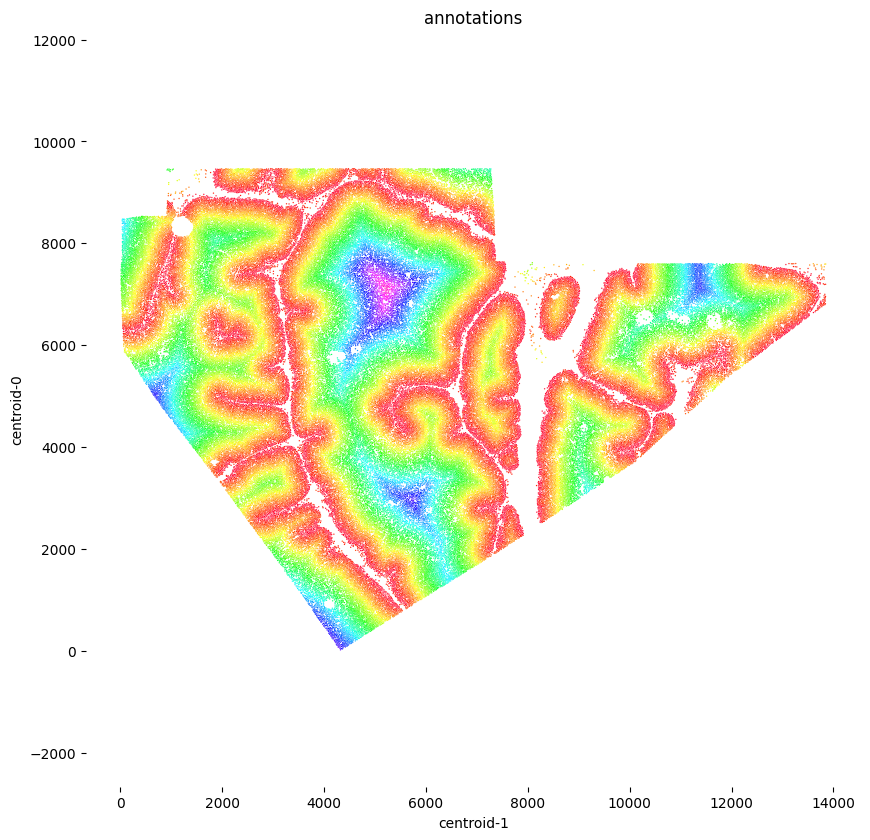

In [37]:
import seaborn as sns
plt.figure(dpi=100, figsize=[10,10])
sns.scatterplot(df_cells['centroid-1'],df_cells['centroid-0'],c= df_cells['L2_dist_annotations_Edge'],cmap='gist_rainbow',s=1)
plt.grid(False)
plt.title('annotations')
plt.axis('equal')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


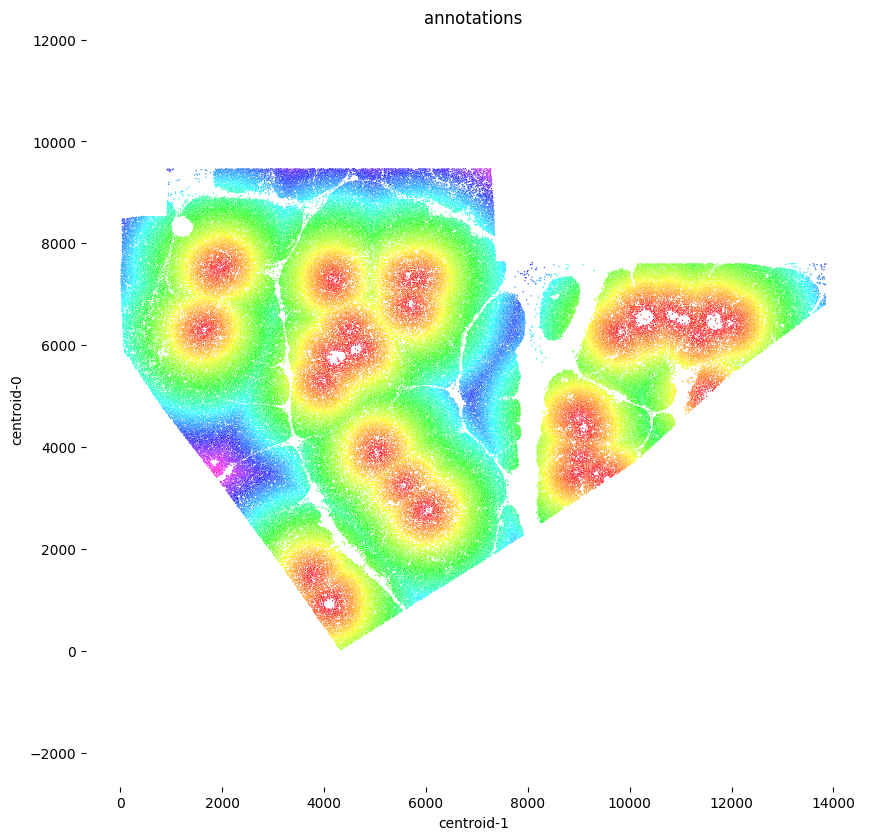

In [38]:
import seaborn as sns
plt.figure(dpi=100, figsize=[10,10])
sns.scatterplot(df_cells['centroid-1'],df_cells['centroid-0'],c= df_cells['L2_dist_annotations_HS'],cmap='gist_rainbow',s=1)
plt.grid(False)
plt.title('annotations')
plt.axis('equal')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


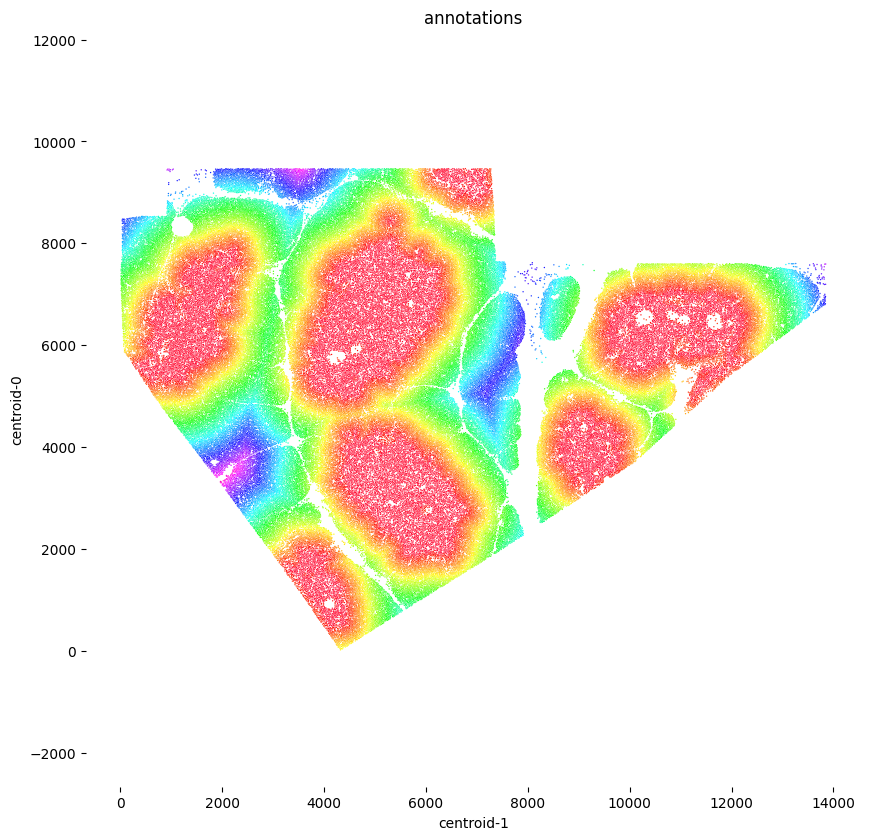

In [39]:
import seaborn as sns
plt.figure(dpi=100, figsize=[10,10])
sns.scatterplot(df_cells['centroid-1'],df_cells['centroid-0'],c= df_cells['L2_dist_annotations_Medulla'],cmap='gist_rainbow',s=1)
plt.grid(False)
plt.title('annotations')
plt.axis('equal')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()